# Study 1: Spectral Line Density

Here we compare telluric and stellar line density for some example spectra.

In [1]:
import torch
from blase.emulator import SparseLogEmulator
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Let's do everything identically as the Step 1 tutorial.

In [3]:
wl_lo = 8079-30
wl_hi = 12785+30

### PHOENIX spectrum

In [4]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

In [5]:
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()
continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")

In [6]:
ln_flux_native = np.log(stellar_spectrum.flux.value)

### TelFit spectrum

In [7]:
#local_file = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp290_hum040.txt'
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [8]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) & 
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

In [9]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`
telluric_lnflux[telluric_lnflux < -15] = -15

In [10]:
%%capture
telluric_emulator = SparseLogEmulator(telluric_wl, telluric_lnflux, 
                             wing_cut_pixels=1000, prominence=0.01, device=device)
telluric_emulator.to(device)

We only want to find the lines, not tune them, so let's just provide a narrow wing cut.

In [11]:
%%capture
stellar_emulator = SparseLogEmulator(stellar_spectrum.wavelength.value, 
                             ln_flux_native, 
                             wing_cut_pixels=1000, prominence=0.01, device=device)
stellar_emulator.to(device)

In [12]:
stellar_lines = stellar_emulator.lam_centers.detach().cpu().numpy()
telluric_lines = telluric_emulator.lam_centers.detach().cpu().numpy()

In [13]:
bins = np.arange(wl_lo, wl_hi, 100.0)

## Make a histogram

We want to identify places with high density of stellar and telluric lines.

(8079.0, 12785.0)

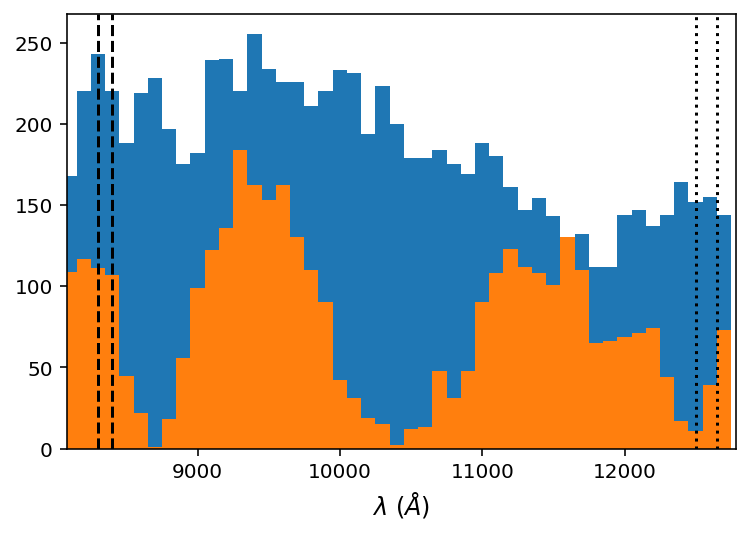

In [22]:
plt.hist(stellar_lines, bins=bins);
plt.hist(telluric_lines, bins=bins);
plt.xlabel('$\lambda ~(\AA)$', fontsize=12)
plt.axvline(8300, linestyle='dashed', color='k')
plt.axvline(8400, linestyle='dashed', color='k')
plt.axvline(12500, linestyle='dotted', color='k')
plt.axvline(12650, linestyle='dotted', color='k')

plt.xlim(wl_lo+30, wl_hi-30)

We will still spot-check a before-and-after:

In [15]:
stellar_emulator.optimize(epochs=300, LR=0.01)

Training Loss: 0.00006362: 100%|█████████████████████████████| 300/300 [00:16<00:00, 18.05it/s]


In [16]:
telluric_emulator.optimize(epochs=300, LR=0.01)

Training Loss: 0.00028582: 100%|█████████████████████████████| 300/300 [00:08<00:00, 34.80it/s]


In [17]:
with torch.no_grad():
    stellar_post = stellar_emulator.forward().cpu().numpy()
    telluric_post = telluric_emulator.forward().cpu().numpy()

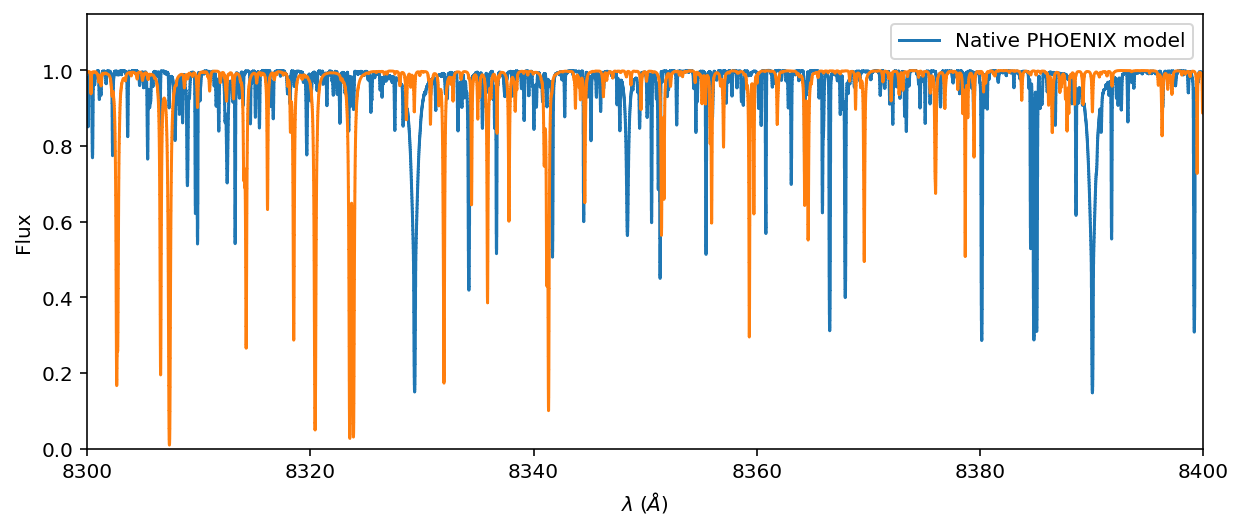

In [18]:
ax = stellar_spectrum.plot(ylo=0.0, yhi=1.15, label='Native PHOENIX model')
telluric_spectrum.plot(ax=ax)
ax.set_xlim(8300, 8400)
ax.legend(loc='upper right');

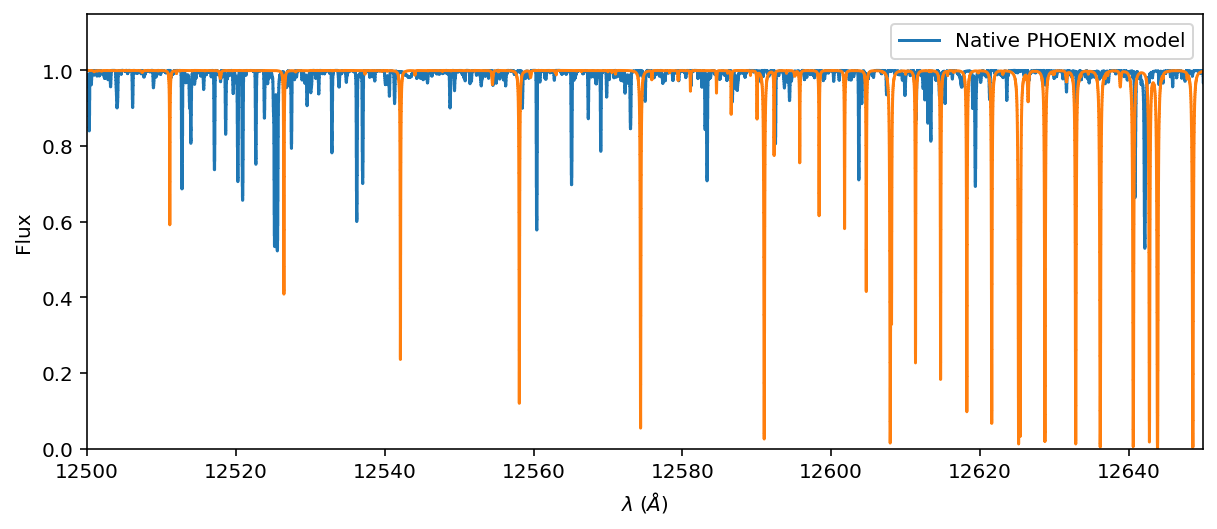

In [23]:
ax = stellar_spectrum.plot(ylo=0.0, yhi=1.15, label='Native PHOENIX model')
telluric_spectrum.plot(ax=ax)
ax.set_xlim(12500, 12650)
ax.legend(loc='upper right');

To be continued...